# IDS.131 Preliminary Analysis
Miranda, Jinghong, Yue, Charlie, Meia

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
from multiprocessing import Pool
from functools import partial

## Load in and Preprocess Data

In [2]:
def _get_path(year, month):
    clean_month = (str(month) if len(str(month)) == 2 else (f'0{month}'))
    return f"data/{str(year)}{clean_month}-bluebikes-tripdata.csv"
    
def preprocess(year, month):
    '''
    Return a numpy array of the data in the csv file specified
    '''
    path = _get_path(year, month)
    try:  
        fo = open(path, "r")
        lines = fo.readlines()
        dataset = [np.array([i.strip("\"").strip('\n') for i in line.split(",")]) for line in lines[1:]]
        return np.vstack(dataset)
    except:
       print(f"Filepath: {path} for year: {year} and month: {month} not found in data folder.")

def get_headers(year, month):
    fo = open(_get_path(year, month), "r")
    return [header.strip("\"").replace(" ", "").strip("\n") for header in fo.readlines()[0].split(",")]

In [3]:
headers = get_headers(2018, 9)

# get the data we want to use
y2018 = {i+1: preprocess(2018, i+1) for i in range(9)}
y2017 = {i: preprocess(2017, i) for i in range(10,13)}

fullyear = np.vstack([month for month in {**y2017, **y2018}.values()])

# map of data column to what that column represents
index_map = {
    key: i for i, key in enumerate(headers)
}

# maps station ids to their respective latitudes and longitudes
station_coordinates = {
    int(row[index_map['endstationid']]):
    (float(row[index_map['endstationlatitude']]), float(row[index_map['endstationlongitude']]))
    for row in fullyear
}

print(headers)
print(index_map)

['tripduration', 'starttime', 'stoptime', 'startstationid', 'startstationname', 'startstationlatitude', 'startstationlongitude', 'endstationid', 'endstationname', 'endstationlatitude', 'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender"']
{'tripduration': 0, 'starttime': 1, 'stoptime': 2, 'startstationid': 3, 'startstationname': 4, 'startstationlatitude': 5, 'startstationlongitude': 6, 'endstationid': 7, 'endstationname': 8, 'endstationlatitude': 9, 'endstationlongitude': 10, 'bikeid': 11, 'usertype': 12, 'birthyear': 13, 'gender"': 14}


In [4]:
def _in_range(time, interval):
    return 1 if (parser.parse(time).hour <= interval[1] and parser.parse(time).hour >= interval[0]) else 0

def _narrow_dataset_by_time(dataset, interval):
    p = Pool(8)
    filtered = p.map(partial(_in_range, interval=interval), [i for i in dataset[:,index_map['starttime']]])
    return dataset[np.array(filtered)==1]
    
def plot_station_use_heat_map(dataset, interval=(0,24), start=True):
    '''
    Plots a heatmap of number of trips starting or ending at a given hubway station by latitude and longitude
    
    Args:
      * interval [tuple(int)]: what hour range to plot (start_hour, end_hour), note this is **inclusive**
      * dataset [np array]: dataset to use in the analysis
      * start [boolean]: plots the stations associated with the start or end of the trip.
                         true for start station false for end station
    '''
    dataset = _narrow_dataset_by_time(dataset.copy(), interval)
    coord = 'startstationid' if start else 'endstationid'
    unique, count = np.unique(dataset[:,index_map[coord]], return_counts=True)
    lat = [station_coordinates[int(i)][0] for i in unique]
    long = [station_coordinates[int(i)][1] for i in unique]
    
    # Plot...
    plt.scatter(long, lat, c=count, s=2, cmap='rainbow')
    buffer = .02
    # adjust axis because of 0 (null) values in lat / long
    plt.ylim((min([i for i in lat if i > 0])-buffer, max(lat)+buffer))
    plt.xlim((min(long)-buffer, max([i for i in long if i < 0])+buffer))
    plt.colorbar()
    plt.show()

In [5]:
morning = (4,10)  # inclusive, so from 4am to 11am.
evening = (16,19)  # inclusive, from 4pm to 8pm

## Station Usage Heat Maps

### For trips during month of sept 2018

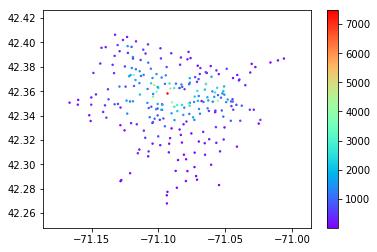

In [7]:
plot_station_use_heat_map(y2018[9], start=True)  # stations where the most trips originate for september 2018

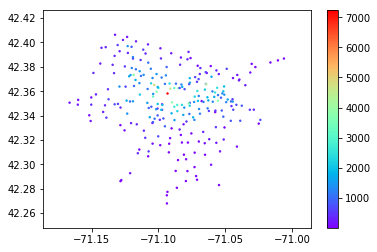

In [8]:
plot_station_use_heat_map(y2018[9], start=False)  # stations where the most trips end for september 2018

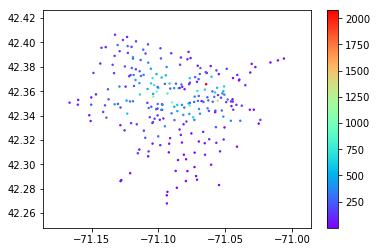

In [9]:
plot_station_use_heat_map(y2018[9], morning, True)  # morning commute origination (starting from 4am to 11am) for september 2018

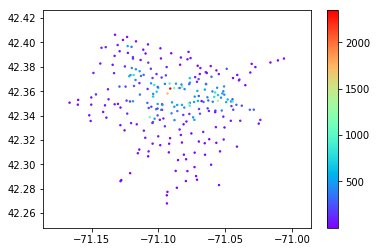

In [10]:
plot_station_use_heat_map(y2018[9], morning, False)  # morning commute destinations (starting from 4am to 11am) for september 2018

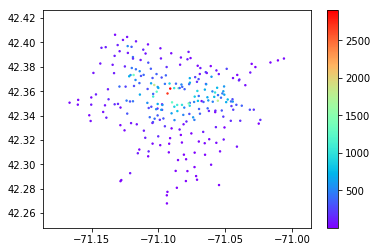

In [11]:
plot_station_use_heat_map(y2018[9], evening, True)  # evening commute origination (4pm to 8pm) for september 2018

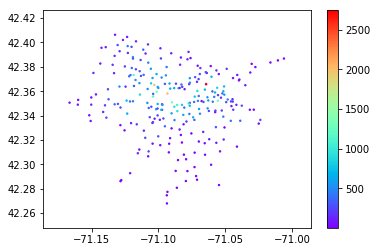

In [12]:
plot_station_use_heat_map(y2018[9], evening, False)  # evening commute destinations (4pm to 8pm) for september 2018

### Heat maps for rides from full past year: oct 2017 - sept 2018 (inclusive)

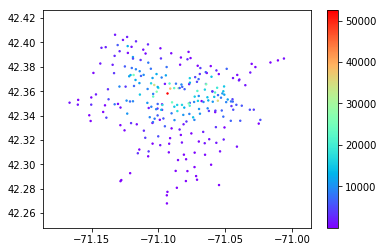

In [13]:
plot_station_use_heat_map(fullyear, start=True)  # stations where the most trips originate for october 2017 to september 2018

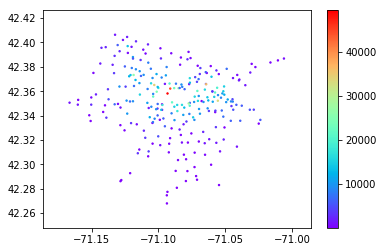

In [17]:
plot_station_use_heat_map(fullyear, start=False)  # stations where the most trips end for october 2017 to september 2018

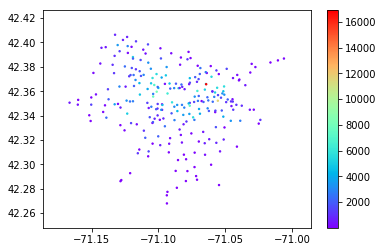

In [18]:
plot_station_use_heat_map(fullyear, morning, True)  # morning commute origination (starting from 4am to 11am)

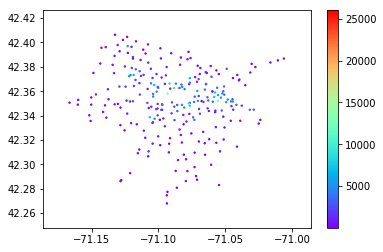

In [19]:
plot_station_use_heat_map(fullyear, morning, False)  # morning commute destinations (starting from 4am to 11am)

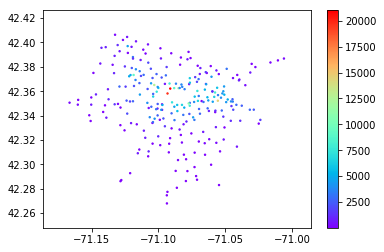

In [20]:
plot_station_use_heat_map(fullyear, evening, True)  # evening commute origination (4pm to 8pm)

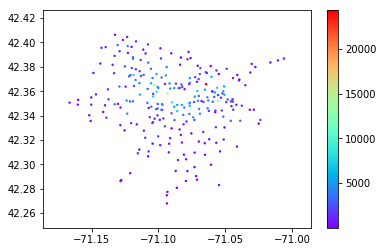

In [21]:
plot_station_use_heat_map(fullyear, evening, False)  # evening commute destinations (4pm to 8pm)

## Analytics of percentage of riders that are subscribers

In [24]:
unique, count = np.unique(fullyear[:,index_map['usertype']], return_counts=True)
print(unique)
print(count)

['Customer' 'Subscriber']
[ 307377 1381146]


In [30]:
diff_start_end = fullyear[fullyear[:,index_map['startstationid']]  != fullyear[:,index_map['endstationid']]]

In [31]:
unique, count = np.unique(diff_start_end[:,index_map['usertype']], return_counts=True)

In [32]:
print(unique, count)

['Customer' 'Subscriber'] [ 272408 1353960]
